# Deep learning approach

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
from glob import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load images

In [13]:
class MelanomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, image_path.split('/')[-1]  # Return filename

In [14]:

data_dir = "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/"
nevus_images = glob(os.path.join(data_dir, "nevus", "*.jpg"))
others_images = glob(os.path.join(data_dir, "others", "*.jpg"))

# Create labels: 1 for nevus, 0 for others
image_paths = nevus_images + others_images
labels = [0] * len(nevus_images) + [1] * len(others_images)

# Split the dataset
train_size = int(0.8 * len(image_paths))
val_size = len(image_paths) - train_size
train_paths, val_paths = random_split(list(zip(image_paths, labels)), [train_size, val_size])

# Separate images and labels in the splits
train_paths, train_labels = zip(*train_paths)
val_paths, val_labels = zip(*val_paths)

In [7]:
train_paths

('C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/others\\bcc01623.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/nevus\\nev04826.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/nevus\\nev01957.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/nevus\\nev07505.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/others\\mel00140.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/others\\mel00212.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/others\\bkl01175.jpg',
 'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/train/train/others\\bcc00115.jpg',
 'C:/Users/User/Desktop/UDG

## Data transformations

In [32]:
from torchvision import transforms

# Define straightforward augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                       # Resize to input size
    transforms.RandomHorizontalFlip(p=0.5),              # Flip horizontally with 50% chance
    transforms.RandomRotation(degrees=15),               # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Random crop and resize for zoom effect
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with standard ImageNet values
])

# Create Datasets and DataLoaders with the updated transformations
train_dataset = MelanomaDataset(train_paths, train_labels, transform=transform)
val_dataset = MelanomaDataset(val_paths, val_labels, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize validation set without augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Visualization

Training Set:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686303..1.0496471].


aaaa tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15294117..1.045656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0696037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09019607..1.0416646].


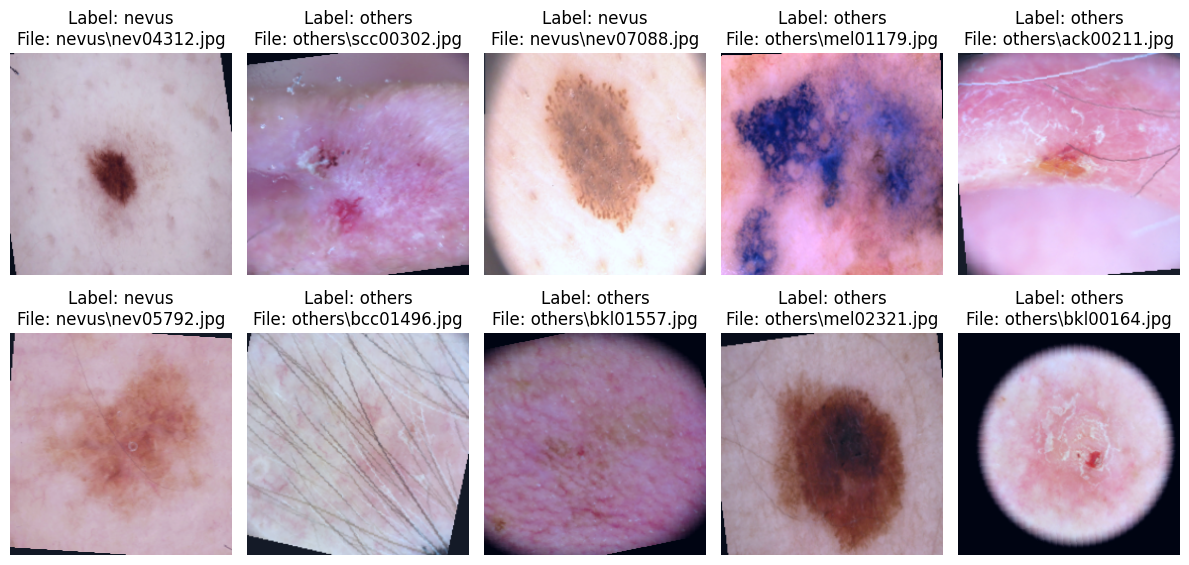

Validation Set:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11103082..1.0536385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0177169].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.0376734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


aaaa tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])


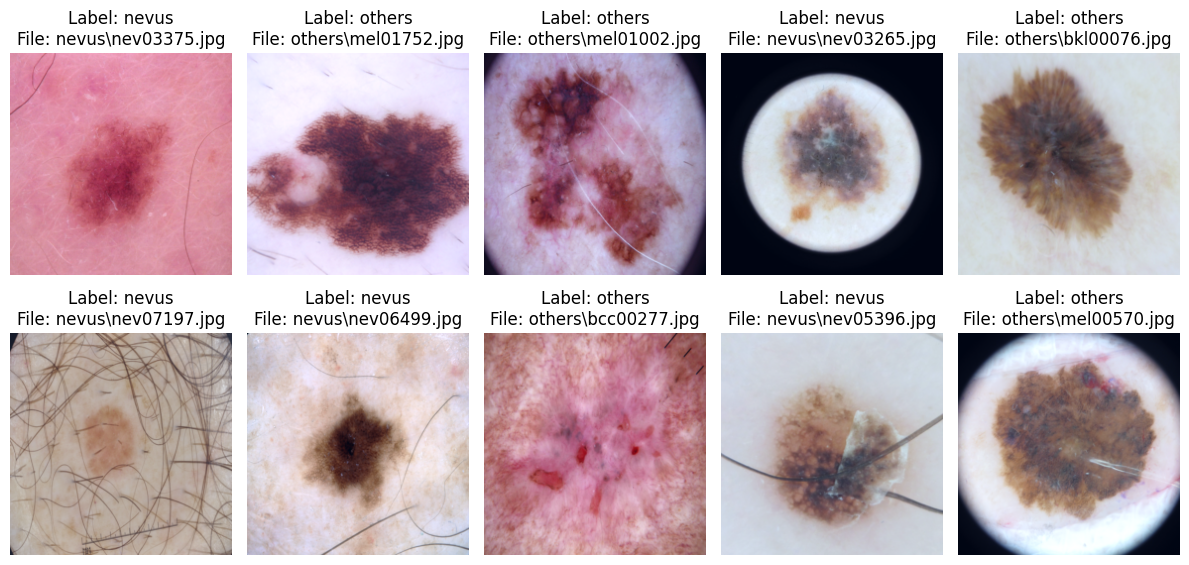

In [33]:
import matplotlib.pyplot as plt
import torch

def visualize_loader(loader, label_map={0: 'nevus', 1: 'others'}, num_images=10):
    """
    Visualize images from a DataLoader with filenames and labels.
    
    Parameters:
    - loader: DataLoader, the DataLoader to visualize from.
    - label_map: dict, mapping of label index to class name.
    - num_images: int, number of images to display.
    """
    images_shown = 0
    plt.figure(figsize=(12, 6))
    
    for images, labels, filenames in loader:
        print("aaaa", labels)
        for i in range(min(num_images, images.size(0))):
            ax = plt.subplot(2, num_images // 2, images_shown + 1)
            image = images[i].permute(1, 2, 0).numpy()  # Change (C, H, W) to (H, W, C)
            image = image * 0.229 + 0.485  # Undo normalization for visualization
            
            label = labels[i].item()
            filename = filenames[i]
            
            ax.imshow(image)
            ax.set_title(f"Label: {label_map[label]}\nFile: {filename}")
            ax.axis("off")
            
            images_shown += 1
            if images_shown >= num_images:
                break
        if images_shown >= num_images:
            break
    
    plt.tight_layout()
    plt.show()

# Visualize training loader images
print("Training Set:")
visualize_loader(train_loader)

# Visualize validation loader images
print("Validation Set:")
visualize_loader(val_loader)


In [35]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()  # For binary classification
)
model = model.to(device)

c:\Users\User\GitHub_Projects\CADx-Project\virtual_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\GitHub_Projects\CADx-Project\virtual_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [39]:

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 15

In [40]:
# Initialize tracking variables for best model
best_val_accuracy = 0.0
best_model_path = 'best_melanoma_model.pth'

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct_preds += (predictions == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            val_loss = criterion(outputs, labels.float())
            val_running_loss += val_loss.item()
            predictions = (outputs > 0.5).float()
            val_correct_preds += (predictions == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct_preds / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Check if this is the best model so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with accuracy: {best_val_accuracy:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Saved best model with accuracy: 0.8006
Epoch 1/15, Train Loss: 0.4520, Train Accuracy: 0.7921, Val Loss: 0.4291, Val Accuracy: 0.8006
Saved best model with accuracy: 0.8082
Epoch 2/15, Train Loss: 0.4414, Train Accuracy: 0.8009, Val Loss: 0.4233, Val Accuracy: 0.8082
Saved best model with accuracy: 0.8141
Epoch 3/15, Train Loss: 0.4308, Train Accuracy: 0.8041, Val Loss: 0.4185, Val Accuracy: 0.8141
Epoch 4/15, Train Loss: 0.4257, Train Accuracy: 0.8040, Val Loss: 0.4306, Val Accuracy: 0.8098
Epoch 5/15, Train Loss: 0.4213, Train Accuracy: 0.8071, Val Loss: 0.4209, Val Accuracy: 0.8016
Saved best model with accuracy: 0.8240
Epoch 6/15, Train Loss: 0.4144, Train Accuracy: 0.8130, Val Loss: 0.3994, Val Accuracy: 0.8240
Epoch 7/15, Train Loss: 0.4053, Train Accuracy: 0.8160, Val Loss: 0.4125, Val Accuracy: 0.8184
Epoch 8/15, Train Loss: 0.4004, Train Accuracy: 0.8152, Val Loss: 0.4039, Val Accuracy: 0.8170
Epoch 9/15, Train Loss: 0.3961, Train Accuracy: 0.8229, Val Loss: 0.3992, Val Accura

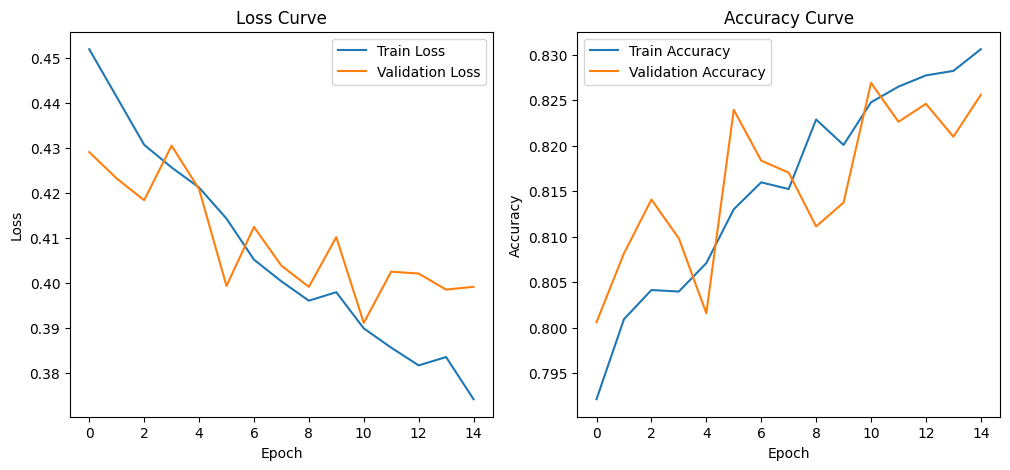

In [41]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

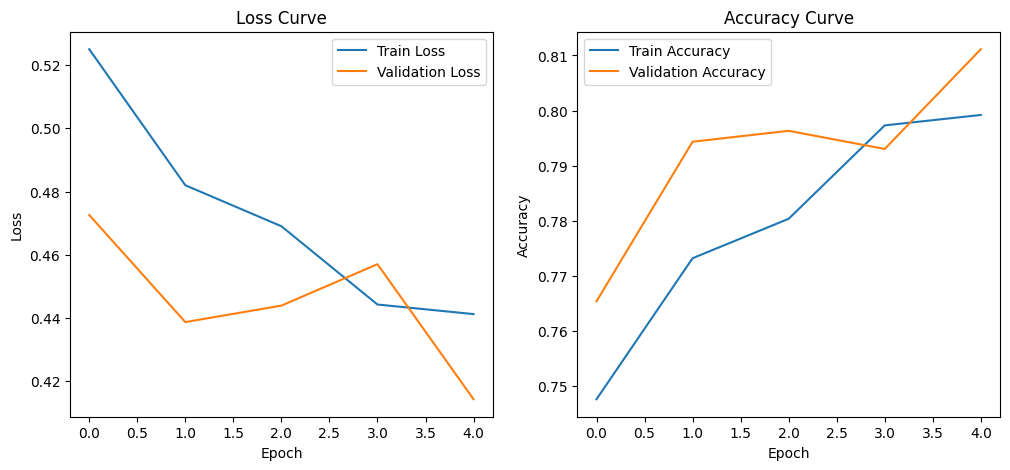

In [38]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

# Apply model in new data

### Load data

In [43]:
from glob import glob
import os

# Define the test data directory path
test_data_dir = "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/val/val/"

# Load image paths
nevus_test_images = glob(os.path.join(test_data_dir, "nevus", "*.jpg"))
others_test_images = glob(os.path.join(test_data_dir, "others", "*.jpg"))

# Create labels for the test set: 0 for nevus, 1 for others
test_image_paths = nevus_test_images + others_test_images
test_labels = [0] * len(nevus_test_images) + [1] * len(others_test_images)

# Combine test paths and labels for easy handling
test_data = list(zip(test_image_paths, test_labels))

# Separate paths and labels
test_paths, test_labels = zip(*test_data)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = MelanomaDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Predict on test set
import pandas as pd

test_predictions = []
file_names = []

with torch.no_grad():
    for images, _, file_paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions = (outputs > 0.5).float()
        
        test_predictions.extend(predictions.cpu().numpy().flatten())
        file_names.extend(file_paths)  # assuming file_paths holds the names or paths of images

# Save predictions to CSV
results = pd.DataFrame({'file_name': file_names, 'label': test_predictions})
results['label'] = results['label'].astype(int)  # Ensure labels are integers (0 or 1)
results.to_csv('test_predictions.csv', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_28528\3510453121.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


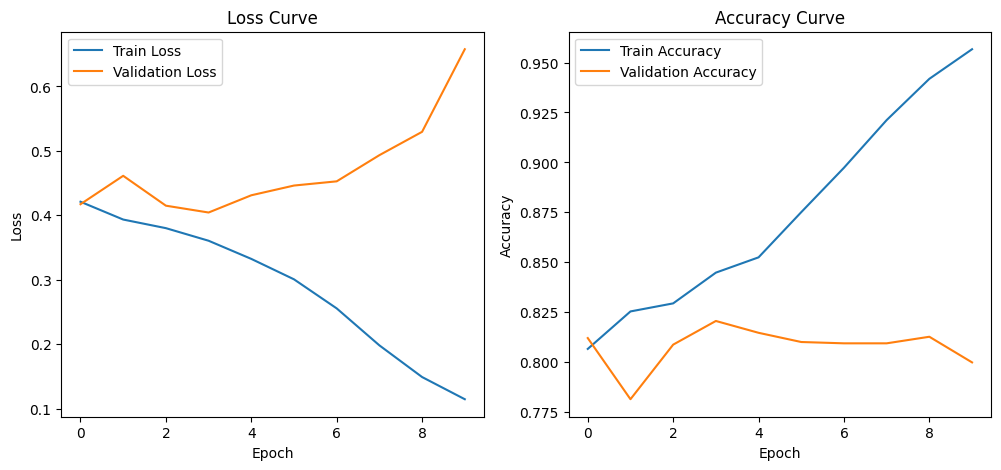

In [28]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()